In [1]:
import sys
from pathlib import Path
sys.path.append('../src')

import pandas as pd
import numpy as np
import torch
import torch.nn as nn

try:
    from sentence_transformers import SentenceTransformer
    SENTENCE_TRANSFORMERS_AVAILABLE = True
except ImportError as e:
    SENTENCE_TRANSFORMERS_AVAILABLE = False
    from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import cv2
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import re
import joblib
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from config import config, hardware_config

device = torch.device("mps") if hardware_config.use_mps and torch.backends.mps.is_available() else torch.device("cpu")

In [2]:
## 1. Load Data and Prepare for Multi-Modal Processing

# Load imputed dataset and training pairs
listings_imputed = pd.read_csv("../data/processed/listings_imputed.csv")
train_pairs = pd.read_csv("../data/processed/train_pairs.csv")
test_pairs = pd.read_csv("../data/processed/test_pairs.csv")

print(f"   Imputed listings: {len(listings_imputed):,}")
print(f"   Train pairs: {len(train_pairs):,}")
print(f"   Test pairs: {len(test_pairs):,}")

# Create lookup dictionary for fast listing access
listings_dict = listings_imputed.set_index('listing_id').to_dict('index')

   Imputed listings: 1,428
   Train pairs: 6,677
   Test pairs: 1,563


In [3]:
## For structured features used in the first model, no need for model setup

In [4]:
# text_model = SentenceTransformer(config.text_model_name)
# text_model.eval()

# # Test encoding to verify model works
# test_text = "Appartement 3 pièces avec balcon à Conflans-Sainte-Honorine"
# test_encoding = text_model.encode(test_text)
# print(f"Text model loaded: {config.text_model_name}")
# print(f"Embedding dimension: {len(test_encoding)}")
# print(f"   Test encoding shape: {test_encoding.shape}")

In [5]:
## Initialze model to process Text Data for Semantic Features

if SENTENCE_TRANSFORMERS_AVAILABLE:
    text_model = SentenceTransformer(config.text_model_name)
    text_model.eval()
    text_processor = text_model
else:
    text_model = TfidfVectorizer(
        max_features=1000,
        stop_words='french',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8
    )
    text_processor = text_model


In [6]:
## Initialze model to process image Data

# Load pre-trained ResNet50
image_model = getattr(models, config.image_model_name)(pretrained=True)
image_model.eval()
image_model = image_model.to(device)

# Remove final classification layer to get features
image_feature_extractor = nn.Sequential(*list(image_model.children())[:-1])

# Image preprocessing pipeline
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Freature dimension is fixed for ResNet50: 2048
# Test image processing
def load_and_preprocess_image(image_path):
    """Load and preprocess single image"""
    try:
        image = Image.open(image_path).convert('RGB')
        return image_transform(image).unsqueeze(0)
    except Exception as e:
        return None

# Test with sample images
sample_images = list(Path(f"../data/{config.pictures_dir}").glob("*.jpg"))[:1]
if sample_images:
    test_tensor = load_and_preprocess_image(sample_images[0])
    if test_tensor is not None:
        print(f"Image preprocessing verified: {test_tensor.shape}")
else:
    print("No sample images found for testing")

Image preprocessing verified: torch.Size([1, 3, 224, 224])


In [12]:
## Structured Feature Extraction

structured_feature_names = [
    'price_similarity', 'surface_similarity', 'price_per_m2_consistency',
    'room_match', 'floor_similarity', 'floor_count_match', 'structured_consistency'
]

def extract_structured_features_pair(listing_A, listing_B):
    """
    Extract 7 structured features comparing two listings
    Returns: list of 7 numerical features
    """
    features = []
    
    # Feature 1: Price similarity
    price_A = listing_A.get('current_price', 0)
    price_B = listing_B.get('current_price', 0)
    
    if price_A > 0 and price_B > 0:
        price_sim = 1 - abs(price_A - price_B) / max(price_A, price_B)
    else:
        price_sim = 0.0
    features.append(price_sim)
    
    # Feature 2: Surface similarity
    surface_A = listing_A.get('surface_m2', 0)
    surface_B = listing_B.get('surface_m2', 0)
    
    if surface_A > 0 and surface_B > 0:
        surface_sim = 1 - abs(surface_A - surface_B) / max(surface_A, surface_B)
    else:
        surface_sim = 0.0
    features.append(surface_sim)
    
    # Feature 3: Price per m² consistency
    if all(x > 0 for x in [price_A, price_B, surface_A, surface_B]):
        ppm2_A = price_A / surface_A
        ppm2_B = price_B / surface_B
        ppm2_sim = 1 - abs(ppm2_A - ppm2_B) / max(ppm2_A, ppm2_B)
    else:
        ppm2_sim = 0.0
    features.append(ppm2_sim)
    
    # Feature 4: Room count match
    room_A = listing_A.get('room_count', None)
    room_B = listing_B.get('room_count', None)
    
    if room_A is not None and room_B is not None:
        room_match = 1.0 if room_A == room_B else 0.0
    else:
        room_match = 0.5
    features.append(room_match)
    
    # Feature 5: Floor similarity
    floor_A = listing_A.get('floor', None)
    floor_B = listing_B.get('floor', None)
    
    if floor_A is not None and floor_B is not None:
        if floor_A == floor_B:
            floor_sim = 1.0
        else:
            floor_diff = abs(float(floor_A) - float(floor_B))
            floor_sim = max(0.0, 1.0 - floor_diff / 5.0)
    else:
        floor_sim = 0.5
    features.append(floor_sim)
    
    # Feature 6: Floor count match
    floor_count_A = listing_A.get('floor_count', None)
    floor_count_B = listing_B.get('floor_count', None)
    
    if floor_count_A is not None and floor_count_B is not None:
        floor_count_match = 1.0 if floor_count_A == floor_count_B else 0.0
    else:
        floor_count_match = 0.5
    features.append(floor_count_match)
    
    # Feature 7: Overall structured consistency
    valid_features = [f for f in features[:6] if f != 0.5 and f > 0]
    consistency_score = np.mean(valid_features) if valid_features else 0.0
    features.append(consistency_score)
    
    return features

def extract_structured_features_batch(pairs_df, listings_dict):
    """Extract structured features for all pairs"""
    feature_matrix = []
    labels = []
        
    for _, row in tqdm(pairs_df.iterrows(), total=len(pairs_df), desc="Structured features"):
        try:
            listing_A = listings_dict[row['listing_id_1']]
            listing_B = listings_dict[row['listing_id_2']]
            
            features = extract_structured_features_pair(listing_A, listing_B)
            feature_matrix.append(features)
            labels.append(row['label'])
            
        except Exception as e:
            print(f"Warning: Failed for pair {row['listing_id_1']}, {row['listing_id_2']}: {e}")
            feature_matrix.append([0.0] * 7)  # Zero vector for failed extractions
            labels.append(row['label'])
    
    return np.array(feature_matrix), np.array(labels)

# Extract structured features for train and test sets
X_structured_train, y_train = extract_structured_features_batch(train_pairs, listings_dict)

X_structured_test, y_test = extract_structured_features_batch(test_pairs, listings_dict)

print(f"   Train shape: {X_structured_train.shape}")
print(f"   Test shape: {X_structured_test.shape}")


Structured features: 100%|██████████| 1563/1563 [00:00<00:00, 83276.56it/s]

   Train shape: (6677, 7)
   Test shape: (1563, 7)


In [8]:
## Extract Text Features

def extract_text_features_pair_bert(desc_A, desc_B, text_model):
    """Extract text features using Sentence-BERT"""

    desc_A = str(desc_A) if pd.notna(desc_A) else ""
    desc_B = str(desc_B) if pd.notna(desc_B) else ""
    
    features = {}
    
    # Get embeddings
    if len(desc_A.strip()) > 0:
        embedding_A = text_model.encode([desc_A])[0]
    else:
        embedding_A = np.zeros(text_model.get_sentence_embedding_dimension())
    
    if len(desc_B.strip()) > 0:
        embedding_B = text_model.encode([desc_B])[0]
    else:
        embedding_B = np.zeros(text_model.get_sentence_embedding_dimension())
    
    features['embedding_A'] = embedding_A
    features['embedding_B'] = embedding_B
    
    # Feature 1: Semantic similarity
    if len(desc_A.strip()) > 0 and len(desc_B.strip()) > 0:
        semantic_sim = cosine_similarity([embedding_A], [embedding_B])[0][0]
    else:
        semantic_sim = 0.0
    features['semantic_similarity'] = float(semantic_sim)
    
    return features

def extract_text_features_pair_tfidf(desc_A, desc_B, tfidf_vectorizer, fitted_vectors=None):
    """Extract text features using TF-IDF"""

    desc_A = str(desc_A) if pd.notna(desc_A) else ""
    desc_B = str(desc_B) if pd.notna(desc_B) else ""
    
    features = {}
    
    if fitted_vectors is not None:
        # Use pre-fitted vectorizer (for batch processing)
        if len(desc_A.strip()) > 0 and len(desc_B.strip()) > 0:
            vectors = tfidf_vectorizer.transform([desc_A, desc_B])
            semantic_sim = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]
        else:
            semantic_sim = 0.0
    else:
        # Fit on the fly (less efficient but works)
        if len(desc_A.strip()) > 0 and len(desc_B.strip()) > 0:
            vectors = tfidf_vectorizer.fit_transform([desc_A, desc_B])
            semantic_sim = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]
        else:
            semantic_sim = 0.0
    
    features['semantic_similarity'] = float(semantic_sim)
    features['embedding_A'] = np.zeros(100)  # Placeholder for compatibility
    features['embedding_B'] = np.zeros(100) 
    
    return features

def extract_common_text_features(desc_A, desc_B):
    """Extract features common to both approaches"""
    desc_A = str(desc_A) if pd.notna(desc_A) else ""
    desc_B = str(desc_B) if pd.notna(desc_B) else ""
    
    features = {}
    
    # Feature 2: Description length ratio
    len_A = len(desc_A.strip())
    len_B = len(desc_B.strip())
    
    if len_A > 0 and len_B > 0:
        length_ratio = min(len_A, len_B) / max(len_A, len_B)
    else:
        length_ratio = 0.0
    features['length_ratio'] = length_ratio
    
    # Feature 3: Real estate keyword overlap
    domaine_keywords = {
        'location': ['proche', 'gare', 'commerce', 'école', 'transport', 'métro', 'rer', 'bus', 'train', 'centre', 'quartier', 'commodité'],
        'features': ['balcon', 'terrasse', 'cave', 'parking', 'ascenseur', 'gardien', 'jardin', 'cheminée', 'vis-a-vis'],
        'condition': ['rénové', 'refait', 'neuf', 'ancien', 'lumineux', 'calme', 'isolé'],
        'rooms': ['séjour', 'salon', 'cuisine', 'chambre', 'salle', 'bain', 'wc', 'dressing', 'hall', 'buanderie', 'grenier'],
        'building': ['étage', 'immeuble', 'résidence', 'copropriété', 'charges', 'fermé', 'sécurisée']
    }
    
    def extract_keywords(text):
        text_lower = text.lower()
        found_keywords = set()
        for category, words in domaine_keywords.items():
            for word in words:
                if word in text_lower:
                    found_keywords.add(word)
        return found_keywords
    
    keywords_A = extract_keywords(desc_A)
    keywords_B = extract_keywords(desc_B)
    
    if len(keywords_A) > 0 or len(keywords_B) > 0:
        intersection = len(keywords_A.intersection(keywords_B))
        union = len(keywords_A.union(keywords_B))
        keyword_overlap = intersection / union if union > 0 else 0.0
    else:
        keyword_overlap = 0.0
    features['keyword_overlap'] = keyword_overlap
    
    return features

def extract_text_features_batch(pairs_df, listings_dict, text_processor):
    """Extract text features for all pairs"""
    all_features = []
    embeddings_A = []
    embeddings_B = []
    labels = []
        
    # TF-IDF if transformer not available
    if not SENTENCE_TRANSFORMERS_AVAILABLE:
        all_descriptions = []
        for _, row in pairs_df.iterrows():
            try:
                listing_A = listings_dict[row['listing_id_1']]
                listing_B = listings_dict[row['listing_id_2']]
                desc_A = str(listing_A.get('description', ''))
                desc_B = str(listing_B.get('description', ''))
                if len(desc_A.strip()) > 0:
                    all_descriptions.append(desc_A)
                if len(desc_B.strip()) > 0:
                    all_descriptions.append(desc_B)
            except:
                continue
        
        if all_descriptions:
            text_processor.fit(all_descriptions)
    
    for _, row in tqdm(pairs_df.iterrows(), total=len(pairs_df), desc="Text features"):
        try:
            listing_A = listings_dict[row['listing_id_1']]
            listing_B = listings_dict[row['listing_id_2']]
            
            desc_A = listing_A.get('description', '')
            desc_B = listing_B.get('description', '')
            
            # Extract features based on available method
            if SENTENCE_TRANSFORMERS_AVAILABLE:
                features = extract_text_features_pair_bert(desc_A, desc_B, text_processor)
            else:
                features = extract_text_features_pair_tfidf(desc_A, desc_B, text_processor)
            
            # Add common features
            common_features = extract_common_text_features(desc_A, desc_B)
            features.update(common_features)
            
            # Store computed features
            text_feature_vector = [
                features['semantic_similarity'],
                features['length_ratio'],
                features['keyword_overlap']
            ]
            all_features.append(text_feature_vector)
            
            # Store embeddings
            embeddings_A.append(features['embedding_A'])
            embeddings_B.append(features['embedding_B'])
            labels.append(row['label'])
            
        except Exception as e:
            print(f"Warning: Failed for pair {row['listing_id_1']}, {row['listing_id_2']}: {e}")
            all_features.append([0.0, 0.0, 0.0])
            embeddings_A.append(np.zeros(100))
            embeddings_B.append(np.zeros(100))
            labels.append(row['label'])
    
    return {
        'features': np.array(all_features),
        'embeddings_A': np.array(embeddings_A),
        'embeddings_B': np.array(embeddings_B),
        'labels': np.array(labels)
    }

# Extract text features for train and test sets
print("📊 Extracting text features for training set...")
text_train_data = extract_text_features_batch(train_pairs, listings_dict, text_processor)

print("📊 Extracting text features for test set...")
text_test_data = extract_text_features_batch(test_pairs, listings_dict, text_processor)

print(f"Text features extraction complete:")
print(f"   Train features shape: {text_train_data['features'].shape}")
print(f"   Train embeddings shape: {text_train_data['embeddings_A'].shape}")
print(f"   Test features shape: {text_test_data['features'].shape}")
print(f"   Method used: {'Sentence-BERT' if SENTENCE_TRANSFORMERS_AVAILABLE else 'TF-IDF'}")

# Handle any NaN values
text_train_data['features'] = np.nan_to_num(text_train_data['features'], nan=0.0)
text_test_data['features'] = np.nan_to_num(text_test_data['features'], nan=0.0)

📊 Extracting text features for training set...


Text features: 100%|██████████| 6677/6677 [02:58<00:00, 37.50it/s]


📊 Extracting text features for test set...


Text features: 100%|██████████| 1563/1563 [00:42<00:00, 36.48it/s]

Text features extraction complete:
   Train features shape: (6677, 3)
   Train embeddings shape: (6677, 384)
   Test features shape: (1563, 3)
   Method used: Sentence-BERT


In [9]:
# Extract Image Features

def get_listing_images(listing_id, pictures_dir, max_images=5):
    picture_path = Path(pictures_dir)
    image_paths = []
    
    # Try different naming patterns
    for i in range(1, max_images + 1):
        img_path = picture_path / f"{listing_id}_{i}.jpg"
        if img_path.exists():
            image_paths.append(img_path)
    
    # Try single image without suffix
    if not image_paths:
        img_path = picture_path / f"{listing_id}.jpg"
        if img_path.exists():
            image_paths.append(img_path)
    
    return image_paths

def extract_image_features_from_paths(image_paths, model, device, transform, batch_size=16):
    """Extract ResNet50 features from image paths"""
    if not image_paths:
        return np.array([])
    
    features = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_tensors = []
        
        for path in batch_paths:
            tensor = load_and_preprocess_image(path)
            if tensor is not None:
                batch_tensors.append(tensor)
        
        if batch_tensors:
            # Stack into batch and process
            batch_tensor = torch.cat(batch_tensors, dim=0).to(device)
            
            with torch.no_grad():
                batch_features = model(batch_tensor)
                batch_features = batch_features.view(batch_features.size(0), -1)  # Flatten
                features.extend(batch_features.cpu().numpy())
    
    return np.array(features) if features else np.array([])

def calculate_image_similarity_features(features_A, features_B):
    """Calculate max and average similarity between image feature sets"""
    if len(features_A) == 0 or len(features_B) == 0:
        return [0.0, 0.0]
    
    similarities = cosine_similarity(features_A, features_B)
    
    max_sim = np.max(similarities)
    
    avg_sim = np.mean(similarities)
    
    return [float(max_sim), float(avg_sim)]

def extract_image_features_batch(pairs_df, listings_dict, image_model, device, transform, pictures_dir):
    """Extract image features for all pairs"""
    all_features = []
    all_embeddings_A = []
    all_embeddings_B = []
    labels = []
        
    for _, row in tqdm(pairs_df.iterrows(), total=len(pairs_df), desc="Image features"):
        try:
            listing_id_A = row['listing_id_1']
            listing_id_B = row['listing_id_2']
            
            # Get image paths
            images_A = get_listing_images(listing_id_A, pictures_dir)
            images_B = get_listing_images(listing_id_B, pictures_dir)
            
            # Extract features
            features_A = extract_image_features_from_paths(
                images_A, image_model, device, transform, hardware_config.image_batch_size
            )
            features_B = extract_image_features_from_paths(
                images_B, image_model, device, transform, hardware_config.image_batch_size
            )
            
            # Calculate similarity features
            similarity_features = calculate_image_similarity_features(features_A, features_B)
            all_features.append(similarity_features)
            
            # Store embeddings (use mean if multiple images)
            if len(features_A) > 0:
                embedding_A = np.mean(features_A, axis=0)
            else:
                embedding_A = np.zeros(2048)
            
            if len(features_B) > 0:
                embedding_B = np.mean(features_B, axis=0)
            else:
                embedding_B = np.zeros(2048)
            
            all_embeddings_A.append(embedding_A)
            all_embeddings_B.append(embedding_B)
            labels.append(row['label'])
            
        except Exception as e:
            print(f"Warning: Faied for pair {listing_id_A}, {listing_id_B}: {e}")
            all_features.append([0.0, 0.0])
            all_embeddings_A.append(np.zeros(2048))
            all_embeddings_B.append(np.zeros(2048))
            labels.append(row['label'])
    
    return {
        'features': np.array(all_features),
        'embeddings_A': np.array(all_embeddings_A),
        'embeddings_B': np.array(all_embeddings_B),
        'labels': np.array(labels)
    }

# Extract image features for train and test sets
pictures_dir = f"../data/{config.pictures_dir}"
image_train_data = extract_image_features_batch(
    train_pairs, listings_dict, image_feature_extractor, device, image_transform, pictures_dir
)

image_test_data = extract_image_features_batch(
    test_pairs, listings_dict, image_feature_extractor, device, image_transform, pictures_dir
)

print(f"Image features extraction complete:")
print(f"  Train features shape: {image_train_data['features'].shape}")
print(f"  Train embeddings shape: {image_train_data['embeddings_A'].shape}")
print(f"  Test features shape: {image_test_data['features'].shape}")
print(f"  Features: 2 image similarity features + embeddings per pair")

Image features: 100%|██████████| 1563/1563 [00:00<00:00, 23801.16it/s]


Image features extraction complete:
  Train features shape: (6677, 2)
  Train embeddings shape: (6677, 2048)
  Test features shape: (1563, 2)
  Features: 2 image similarity features + embeddings per pair



 STRUCTURED FEATURES ANALYSIS:
----------------------------------------
Data shape: (6677, 7)
Positive samples: 1742
Negative samples: 4935
  price_similarity         : pos=0.971, neg=0.778, disc=0.193
  surface_similarity       : pos=0.997, neg=0.762, disc=0.235
  price_per_m2_consistency : pos=0.970, neg=0.811, disc=0.159
  room_match               : pos=0.999, neg=0.291, disc=0.708
  floor_similarity         : pos=0.904, neg=0.556, disc=0.348
  floor_count_match        : pos=0.888, neg=0.393, disc=0.495
  structured_consistency   : pos=0.988, neg=0.798, disc=0.190

 TEXT FEATURES ANALYSIS:
----------------------------------------
Data shape: (6677, 3)
Positive samples: 1742
Negative samples: 4935
  semantic_similarity      : pos=0.891, neg=0.572, disc=0.319
  description_length_ratio : pos=0.904, neg=0.700, disc=0.205
  keyword_overlap          : pos=0.864, neg=0.366, disc=0.498

 IMAGE FEATURES ANALYSIS:
----------------------------------------
Data shape: (6677, 2)
Positive sampl

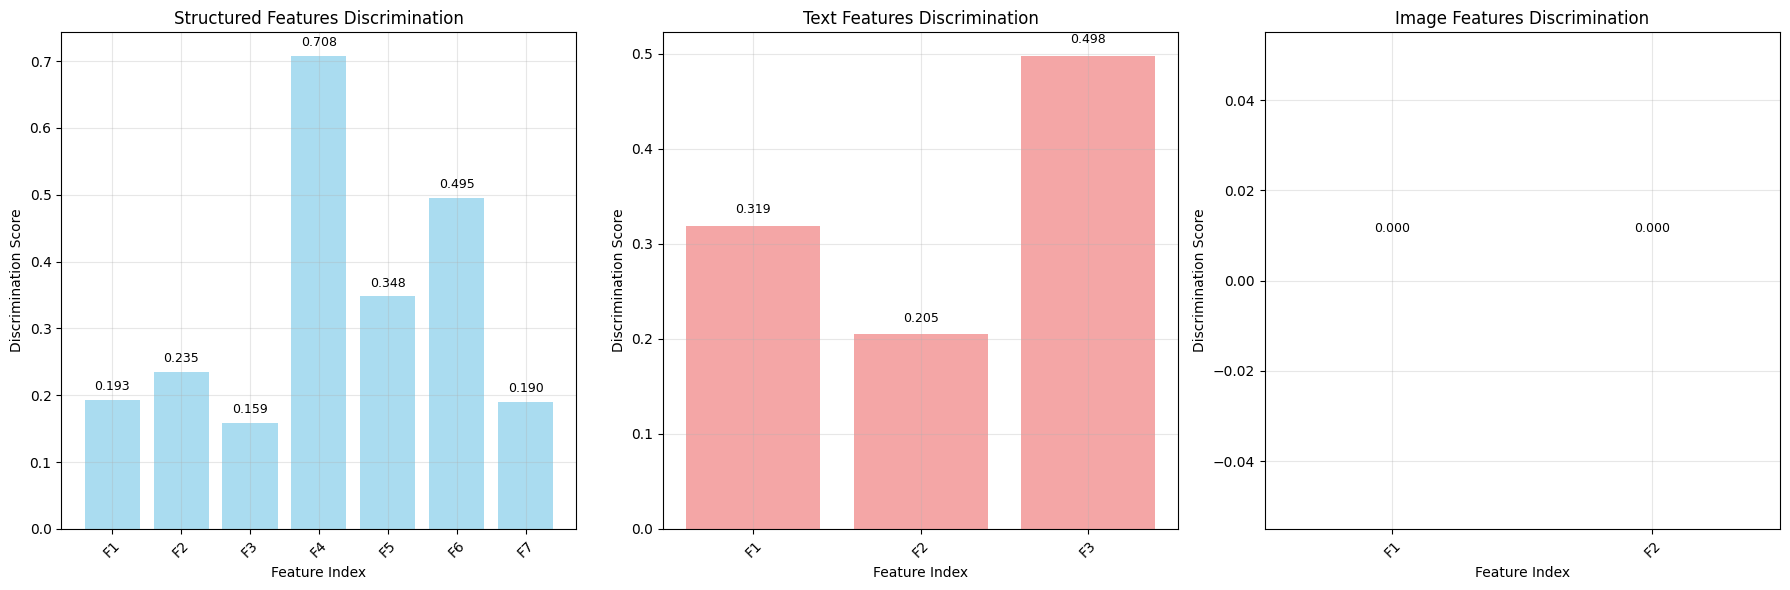


🎯 TOP DISCRIMINATIVE FEATURES BY MODALITY:
   Structured  : room_match (discrimination: 0.708)
   Text        : keyword_overlap (discrimination: 0.498)
   Image       : max_image_similarity (discrimination: 0.000)


In [ ]:
# Feature Analysis and Visualization

# Define feature names for all modalities (already defined for structured above)
text_feature_names = [
    'semantic_similarity', 'description_length_ratio', 'keyword_overlap'
]

image_feature_names = [
    'max_image_similarity', 'avg_image_similarity'
]


# def analyze_modality_features(features, labels, feature_names, modality_name):
#     """Analyze feature distributions for a specific modality"""
#     print(f"\n {modality_name.upper()} FEATURES ANALYSIS:")
#     print("-" * 40)
    
#     pos_indices = labels == 1
#     neg_indices = labels == 0
    
#     print(f"Data shape: {features.shape}")
#     print(f"Positive samples: {pos_indices.sum()}")
#     print(f"Negative samples: {neg_indices.sum()}")
    
#     # Feature statistics
#     feature_stats = []
#     for i, name in enumerate(feature_names):
#         pos_mean = features[pos_indices, i].mean()
#         neg_mean = features[neg_indices, i].mean()
#         discrimination = abs(pos_mean - neg_mean)
        
#         feature_stats.append({
#             'feature': name,
#             'pos_mean': pos_mean,
#             'neg_mean': neg_mean,
#             'discrimination': discrimination,
#             'overall_mean': features[:, i].mean(),
#             'overall_std': features[:, i].std()
#         })
        
#         print(f"  {name:<25}: pos={pos_mean:.3f}, neg={neg_mean:.3f}, disc={discrimination:.3f}")
    
#     return feature_stats

# # Analyze each modality
# structured_stats = analyze_modality_features(
#     X_structured_train, y_train, structured_feature_names, "Structured"
# )

# text_stats = analyze_modality_features(
#     text_train_data['features'], text_train_data['labels'], text_feature_names, "Text"
# )

# image_stats = analyze_modality_features(
#     image_train_data['features'], image_train_data['labels'], image_feature_names, "Image"
# )

# # Create visualization of feature discrimination across modalities
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# # Plot discrimination scores for each modality
# modalities = [
#     ("Structured", structured_stats, structured_feature_names),
#     ("Text", text_stats, text_feature_names),
#     ("Image", image_stats, image_feature_names)
# ]

# for idx, (name, stats, feature_names_viz) in enumerate(modalities):
#     ax = axes[idx]
    
#     discriminations = [s['discrimination'] for s in stats]
#     colors = ['skyblue', 'lightcoral', 'lightgreen'][idx]
    
#     bars = ax.bar(range(len(discriminations)), discriminations, color=colors, alpha=0.7)
#     ax.set_title(f'{name} Features Discrimination')
#     ax.set_xlabel('Feature Index')
#     ax.set_ylabel('Discrimination Score')
#     ax.set_xticks(range(len(feature_names_viz)))
#     ax.set_xticklabels([f'F{i+1}' for i in range(len(feature_names_viz))], rotation=45)
#     ax.grid(True, alpha=0.3)
    
#     # Add value labels on bars
#     for i, bar in enumerate(bars):
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
#                 f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# plt.tight_layout()
# plt.savefig('../data/processed/modality_discrimination.png', dpi=150, bbox_inches='tight')
# plt.show()

# # Summary of best features by modality
# print(f"\n🎯 TOP DISCRIMINATIVE FEATURES BY MODALITY:")
# for name, stats, _ in modalities:
#     top_feature = max(stats, key=lambda x: x['discrimination'])
#     print(f"   {name:<12}: {top_feature['feature']} (discrimination: {top_feature['discrimination']:.3f})")

In [10]:
# Feature Scaling

# Scale structured features for LightGBM
structured_scaler = StandardScaler()
X_structured_train_scaled = structured_scaler.fit_transform(X_structured_train)
X_structured_test_scaled = structured_scaler.transform(X_structured_test)

# Scale text features (for potential ML use beyond Sentence-BERT)
# text_scaler = StandardScaler()
# X_text_train_scaled = text_scaler.fit_transform(text_train_data['features'])
# X_text_test_scaled = text_scaler.transform(text_test_data['features'])

# Scale image features 
image_scaler = StandardScaler()
X_image_train_scaled = image_scaler.fit_transform(image_train_data['features'])
X_image_test_scaled = image_scaler.transform(image_test_data['features'])

In [13]:
# Save feature set 

models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Save structured features and model componentsf
np.savez_compressed(
    models_dir / "structured_features.npz",
    X_train=X_structured_train_scaled,
    X_test=X_structured_test_scaled,
    y_train=y_train,
    y_test=y_test,
    feature_names=structured_feature_names
)
joblib.dump(structured_scaler, models_dir / "structured_scaler.pkl")
print(f"   ✅ Structured features saved: {models_dir}/structured_features.npz")
print(f"   ✅ Structured scaler saved: {models_dir}/structured_scaler.pkl")

# Save text features and model components
print("🤖 Saving text data components...")
np.savez_compressed(
    models_dir / "text_features.npz",
    X_train=X_text_train_scaled,
    X_test=X_text_test_scaled,
    embeddings_train_A=text_train_data['embeddings_A'],
    embeddings_train_B=text_train_data['embeddings_B'],
    embeddings_test_A=text_test_data['embeddings_A'],
    embeddings_test_B=text_test_data['embeddings_B'],
    y_train=text_train_data['labels'],
    y_test=text_test_data['labels'],
    feature_names=text_feature_names
)
joblib.dump(text_scaler, models_dir / "text_scaler.pkl")
# Note: text_model is not saved here as it's loaded directly from sentence-transformers
print(f"   ✅ Text features saved: {models_dir}/text_features.npz")
print(f"   ✅ Text scaler saved: {models_dir}/text_scaler.pkl")
print(f"   ℹ️ Text model: Load directly with SentenceTransformer('{config.text_model_name}')")

# Save image features and model components
print("🖼️ Saving image data components...")
np.savez_compressed(
    models_dir / "image_features.npz",
    X_train=X_image_train_scaled,
    X_test=X_image_test_scaled,
    embeddings_train_A=image_train_data['embeddings_A'],
    embeddings_train_B=image_train_data['embeddings_B'],
    embeddings_test_A=image_test_data['embeddings_A'],
    embeddings_test_B=image_test_data['embeddings_B'],
    y_train=image_train_data['labels'],
    y_test=image_test_data['labels'],
    feature_names=image_feature_names
)
joblib.dump(image_scaler, models_dir / "image_scaler.pkl")
# Note: image_model components saved separately due to PyTorch
torch.save(image_feature_extractor.state_dict(), models_dir / "image_feature_extractor.pth")
print(f"   ✅ Image features saved: {models_dir}/image_features.npz")
print(f"   ✅ Image scaler saved: {models_dir}/image_scaler.pkl")
print(f"   ✅ Image model saved: {models_dir}/image_feature_extractor.pth")

# Save comprehensive feature analysis
print("📊 Saving feature analysis...")
all_stats = {
    'structured': structured_stats,
    'text': text_stats, 
    'image': image_stats
}
joblib.dump(all_stats, models_dir / "feature_analysis.pkl")

# Create summary report
summary_data = {
    'modality': ['Structured', 'Text', 'Image'],
    'n_features': [len(structured_feature_names), len(text_feature_names), len(image_feature_names)],
    'train_samples': [len(X_structured_train), len(X_text_train_scaled), len(X_image_train_scaled)],
    'test_samples': [len(X_structured_test), len(X_text_test_scaled), len(X_image_test_scaled)],
    'top_discrimination': [
        max(structured_stats, key=lambda x: x['discrimination'])['discrimination'],
        max(text_stats, key=lambda x: x['discrimination'])['discrimination'],
        max(image_stats, key=lambda x: x['discrimination'])['discrimination']
    ]
}
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(models_dir / "multimodal_summary.csv", index=False)

print(f"   ✅ Feature analysis saved: {models_dir}/feature_analysis.pkl")
print(f"   ✅ Summary report saved: {models_dir}/multimodal_summary.csv")

print(f"\n📁 ALL ARTIFACTS SAVED TO: {models_dir}")

   ✅ Structured features saved: ../models/structured_features.npz
   ✅ Structured scaler saved: ../models/structured_scaler.pkl
🤖 Saving text data components...


NameError: name 'X_text_train_scaled' is not defined